In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("722I4") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.memory.offHeap.enabled", True) \
    .config("spark.memory.offHeap.size", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/22 16:21:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql.functions import lit, col, from_json, to_json, size, array_contains, map_keys, count, when, isnan,explode, expr, skewness, pow
from pyspark.ml.classification import RandomForestClassifier, LinearSVC
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler,StandardScaler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql.types import MapType, StringType, IntegerType

In [3]:
#To read the datasets
df1 = spark.read.csv(
    'Dataset/TFT_Challenger_MatchData.csv',
    header=True,
    inferSchema=True,
    multiLine=True, 
    quote='"',  
    escape='"'  
)

df2 = spark.read.csv(
    'Dataset/TFT_Diamond_MatchData.csv',
    header=True,
    inferSchema=True,
    multiLine=True,
    quote='"', 
    escape='"'
)

df3 = spark.read.csv(
    'Dataset/TFT_GrandMaster_MatchData.csv',
    header=True,
    inferSchema=True,
    multiLine=True,
    quote='"',
    escape='"'
)

df4 = spark.read.csv(
    'Dataset/TFT_Master_MatchData.csv',
    header=True,
    inferSchema=True,
    multiLine=True,
    quote='"',
    escape='"'
)

df5 = spark.read.csv(
    'Dataset/TFT_Platinum_MatchData .csv',
    header=True,
    inferSchema=True,
    multiLine=True,
    quote='"',
    escape='"'
)

In [4]:
df1.printSchema()
df2.printSchema()
df3.printSchema()
df4.printSchema()
df5.printSchema()

root
 |-- gameId: string (nullable = true)
 |-- gameDuration: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- lastRound: integer (nullable = true)
 |-- Ranked: integer (nullable = true)
 |-- ingameDuration: double (nullable = true)
 |-- combination: string (nullable = true)
 |-- champion: string (nullable = true)

root
 |-- gameId: string (nullable = true)
 |-- gameDuration: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- lastRound: integer (nullable = true)
 |-- Ranked: integer (nullable = true)
 |-- ingameDuration: double (nullable = true)
 |-- combination: string (nullable = true)
 |-- champion: string (nullable = true)

root
 |-- gameId: string (nullable = true)
 |-- gameDuration: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- lastRound: integer (nullable = true)
 |-- Ranked: integer (nullable = true)
 |-- ingameDuration: double (nullable = true)
 |-- combination: string (nullable = true)
 |-- champion: string (nullable =

In [5]:
df1.show()
df2.show()
df3.show()
df4.show()
df5.show()

+-------------+------------+-----+---------+------+--------------+--------------------+--------------------+
|       gameId|gameDuration|level|lastRound|Ranked|ingameDuration|         combination|            champion|
+-------------+------------+-----+---------+------+--------------+--------------------+--------------------+
|KR_4247538593| 2142.470703|    8|       35|     1|   2134.272217|{"DarkStar": 2, "...|{"JarvanIV": {"it...|
|KR_4247538593| 2142.470703|    9|       35|     2|   2134.272217|{"Blaster": 2, "M...|{"Malphite": {"it...|
|KR_4247538593| 2142.470703|    8|       34|     3|   2073.459229|{"Cybernetic": 1,...|{"KaiSa": {"items...|
|KR_4247538593| 2142.470703|    8|       33|     4|   1998.146729|{"Blaster": 1, "C...|{"KaiSa": {"items...|
|KR_4247538593| 2142.470703|    9|       33|     5|   1986.443237|{"Blaster": 2, "D...|{"Ziggs": {"items...|
|KR_4247538593| 2142.470703|    8|       31|     6|   1878.470093|{"Blaster": 2, "D...|{"Ziggs": {"items...|
|KR_4247538593| 214

+-------------+------------+-----+---------+------+--------------+--------------------+--------------------+
|       gameId|gameDuration|level|lastRound|Ranked|ingameDuration|         combination|            champion|
+-------------+------------+-----+---------+------+--------------+--------------------+--------------------+
|KR_4291707834| 1963.905273|    6|       27|     5|   1390.165771|{"Cybernetic": 1,...|{"Ziggs": {"items...|
|KR_4291707834| 1963.905273|    8|       37|     3|   1891.282715|{"Blaster": 1, "C...|{"Ziggs": {"items...|
|KR_4291707834| 1963.905273|    6|       25|     7|    1279.46106|{"Blaster": 1, "C...|{"Fiora": {"items...|
|KR_4291707834| 1963.905273|    7|       38|     2|   1955.608521|{"DarkStar": 1, "...|{"Poppy": {"items...|
|KR_4291707834| 1963.905273|    8|       38|     1|   1955.608521|{"Blaster": 1, "C...|{"TwistedFate": {...|
|KR_4291707834| 1963.905273|    5|       21|     8|   1067.354736|{"Rebel": 1, "Bla...|{"Poppy": {"items...|
|KR_4291707834| 196

In [6]:
df1.describe().show()
df2.describe().show()
df3.describe().show()
df4.describe().show()
df5.describe().show()

+-------+-------------+------------------+------------------+-----------------+-----------------+------------------+--------------------+--------------------+
|summary|       gameId|      gameDuration|             level|        lastRound|           Ranked|    ingameDuration|         combination|            champion|
+-------+-------------+------------------+------------------+-----------------+-----------------+------------------+--------------------+--------------------+
|  count|        79999|             79999|             79999|            79999|            79999|             79999|               79999|               79999|
|   mean|         null|2159.3728157595033| 7.892923661545769|33.75158439480494|4.499981249765622|1885.0097235465466|                null|                null|
| stddev|         null|150.72324734212742|0.7644929118672836|4.764065529197094|2.291310351573228| 266.9176517302617|                null|                null|
|    min|KR_4247538593|       38.88844681|    

+-------+-------------+------------------+------------------+-----------------+------------------+------------------+--------------------+--------------------+
|summary|       gameId|      gameDuration|             level|        lastRound|            Ranked|    ingameDuration|         combination|            champion|
+-------+-------------+------------------+------------------+-----------------+------------------+------------------+--------------------+--------------------+
|  count|        80000|             80000|             80000|            80000|             80000|             80000|               80000|               80000|
|   mean|         null|2156.6076191980155|          7.855675|           33.569|               4.5|1873.9154541819894|                null|                null|
| stddev|         null|137.20649787972252|0.7883863670740987|4.798054477242265|2.2913021681612307| 267.0393253362197|                null|                null|
|    min|KR_3965402291|       123.855659

+-------+-------------+------------------+------------------+----------------+------------------+------------------+--------------------+--------------------+
|summary|       gameId|      gameDuration|             level|       lastRound|            Ranked|    ingameDuration|         combination|            champion|
+-------+-------------+------------------+------------------+----------------+------------------+------------------+--------------------+--------------------+
|  count|        80000|             80000|             80000|           80000|             80000|             80000|               80000|               80000|
|   mean|         null|2154.3420347044225|          7.895225|         33.5867|           4.49965|1875.5377141319298|                null|                null|
| stddev|         null|136.15483538719982|0.7588177626610808|4.79001773622747|2.2916076280242668| 265.4344293875639|                null|                null|
|    min|KR_4254769102|       125.2782974|    

+-------+-------------+------------------+------------------+-----------------+------------------+------------------+--------------------+--------------------+
|summary|       gameId|      gameDuration|             level|        lastRound|            Ranked|    ingameDuration|         combination|            champion|
+-------+-------------+------------------+------------------+-----------------+------------------+------------------+--------------------+--------------------+
|  count|        79999|             79999|             79999|            79999|             79999|             79999|               79999|               79999|
|   mean|         null|2155.4974718969784| 7.841323016537706|33.53115663945799| 4.499331241640521| 1876.467331872744|                null|                null|
| stddev|         null|133.84335177358753|0.7711593848349675|4.784822202970557|2.2919102838214624|267.10705206985534|                null|                null|
|    min|KR_4242528808|       181.108840

+-------+-------------+------------------+------------------+-----------------+------------------+-----------------+--------------------+--------------------+
|summary|       gameId|      gameDuration|             level|        lastRound|            Ranked|   ingameDuration|         combination|            champion|
+-------+-------------+------------------+------------------+-----------------+------------------+-----------------+--------------------+--------------------+
|  count|        80000|             80000|             80000|            80000|             80000|            80000|               80000|               80000|
|   mean|         null|2168.4270788312056|         7.7856375|       33.1931125|          4.496375|1881.922943518915|                null|                null|
| stddev|         null|156.29469546173084|0.8281876552319862|4.878633781673783|2.2942542697809682|279.2132566510513|                null|                null|
|    min|KR_3890408252|               0.0|    

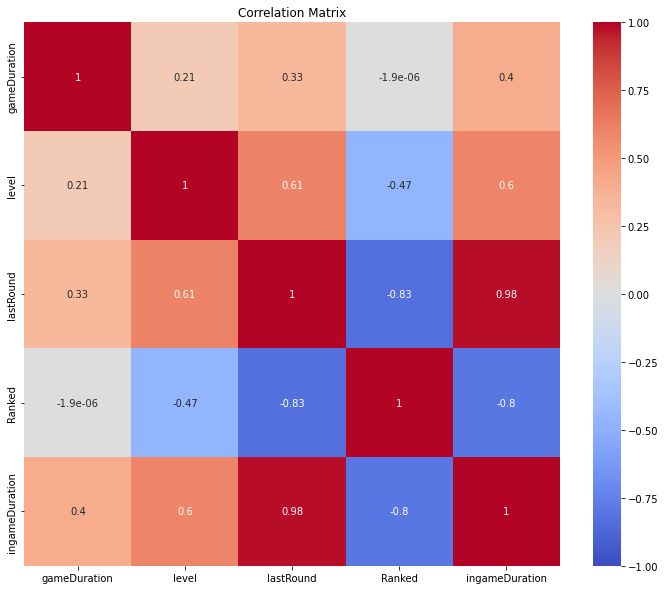

In [9]:
# Correlation Matrix
numeric_columns = ['gameDuration', 'level', 'lastRound', 'Ranked', 'ingameDuration']

numeric_df1 = df1.select(numeric_columns).toPandas()

corr_matrix = numeric_df1.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [4]:
#To add new attribute 'segment'
df1 = df1.withColumn('segment', lit('Challenger'))
df2 = df2.withColumn('segment', lit('Diamond'))
df3 = df3.withColumn('segment', lit('GrandMaster'))
df4 = df4.withColumn('segment', lit('Master'))
df5 = df5.withColumn('segment', lit('Platinum'))

In [8]:
df1.show()
df2.show()
df3.show()
df4.show()
df5.show()

+-------------+------------+-----+---------+------+--------------+--------------------+--------------------+----------+
|       gameId|gameDuration|level|lastRound|Ranked|ingameDuration|         combination|            champion|   segment|
+-------------+------------+-----+---------+------+--------------+--------------------+--------------------+----------+
|KR_4247538593| 2142.470703|    8|       35|     1|   2134.272217|{"DarkStar": 2, "...|{"JarvanIV": {"it...|Challenger|
|KR_4247538593| 2142.470703|    9|       35|     2|   2134.272217|{"Blaster": 2, "M...|{"Malphite": {"it...|Challenger|
|KR_4247538593| 2142.470703|    8|       34|     3|   2073.459229|{"Cybernetic": 1,...|{"KaiSa": {"items...|Challenger|
|KR_4247538593| 2142.470703|    8|       33|     4|   1998.146729|{"Blaster": 1, "C...|{"KaiSa": {"items...|Challenger|
|KR_4247538593| 2142.470703|    9|       33|     5|   1986.443237|{"Blaster": 2, "D...|{"Ziggs": {"items...|Challenger|
|KR_4247538593| 2142.470703|    8|      

+-------------+------------+-----+---------+------+--------------+--------------------+--------------------+--------+
|       gameId|gameDuration|level|lastRound|Ranked|ingameDuration|         combination|            champion| segment|
+-------------+------------+-----+---------+------+--------------+--------------------+--------------------+--------+
|KR_4291707834| 1963.905273|    6|       27|     5|   1390.165771|{"Cybernetic": 1,...|{"Ziggs": {"items...|Platinum|
|KR_4291707834| 1963.905273|    8|       37|     3|   1891.282715|{"Blaster": 1, "C...|{"Ziggs": {"items...|Platinum|
|KR_4291707834| 1963.905273|    6|       25|     7|    1279.46106|{"Blaster": 1, "C...|{"Fiora": {"items...|Platinum|
|KR_4291707834| 1963.905273|    7|       38|     2|   1955.608521|{"DarkStar": 1, "...|{"Poppy": {"items...|Platinum|
|KR_4291707834| 1963.905273|    8|       38|     1|   1955.608521|{"Blaster": 1, "C...|{"TwistedFate": {...|Platinum|
|KR_4291707834| 1963.905273|    5|       21|     8|   10

In [5]:
#To combine five tables
combined_df = df1.unionAll(df2)
combined_df = combined_df.unionAll(df3)
combined_df = combined_df.unionAll(df4)
combined_df = combined_df.unionAll(df5)

In [10]:
combined_df.describe().show()

+-------+-------------+-----------------+------------------+-----------------+------------------+------------------+--------------------+--------------------+----------+
|summary|       gameId|     gameDuration|             level|        lastRound|            Ranked|    ingameDuration|         combination|            champion|   segment|
+-------+-------------+-----------------+------------------+-----------------+------------------+------------------+--------------------+--------------------+----------+
|  count|       399998|           399998|            399998|           399998|            399998|            399998|              399998|              399998|    399998|
|   mean|         null|2158.849411149362| 7.854156770783854|33.52631013155066| 4.499067495337477|1878.5706226108994|                null|                null|      null|
| stddev|         null|143.2137550903731|0.7836338203892036|4.806737439872825|2.2920661600822156| 269.2215033988561|                null|             

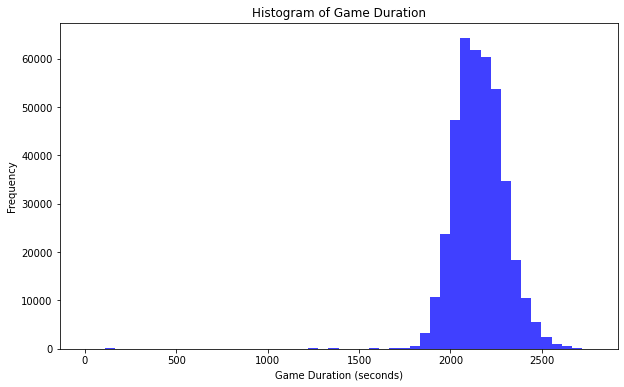

In [11]:
#To create the histogram of ‘gameDuration’
game_durations = combined_df.select('gameDuration').rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 6))
plt.hist(game_durations, bins=50, alpha=0.75, color='blue')
plt.title('Histogram of Game Duration')
plt.xlabel('Game Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

In [6]:
# To replace the missing value of 'gameDuration' with 0
combined_df = combined_df.fillna({'gameDuration': 0})

# To filter out 'gameDuration' greater than or equal to 1200
combined_df = combined_df.filter(col('gameDuration') > 1200)

In [13]:
combined_df.describe().show()

+-------+-------------+------------------+------------------+-----------------+------------------+------------------+--------------------+--------------------+----------+
|summary|       gameId|      gameDuration|             level|        lastRound|            Ranked|    ingameDuration|         combination|            champion|   segment|
+-------+-------------+------------------+------------------+-----------------+------------------+------------------+--------------------+--------------------+----------+
|  count|       399606|            399606|            399606|           399606|            399606|            399606|              399606|              399606|    399606|
|   mean|         null|2160.4056700603833|7.8578599920922105| 33.5488781449728| 4.499924926052161|1879.9135249133747|                null|                null|      null|
| stddev|         null| 133.9105814435461|0.7735742082823168|4.751337711645589|2.2913649793124478|265.74038554889404|                null|       

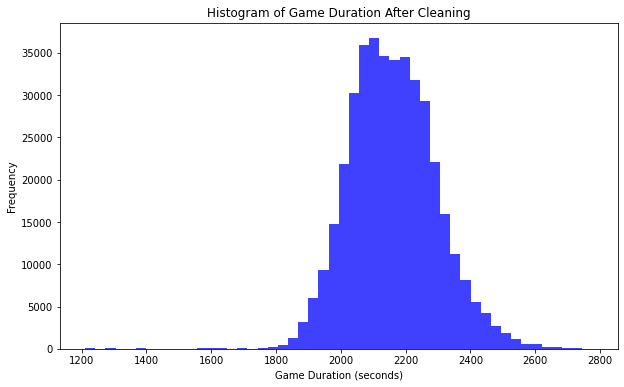

In [14]:
#To create the histogram of ‘gameDuration’ after cleaning
game_durations_filtered = combined_df.select('gameDuration').rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(10, 6))
plt.hist(game_durations_filtered, bins=50, alpha=0.75, color='blue')
plt.title('Histogram of Game Duration After Cleaning')
plt.xlabel('Game Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

In [7]:
# To filter out empty 'combination'

# Set the schema
schema = MapType(StringType(), IntegerType())

# Parse JSON
combined_df = combined_df.withColumn('parsed_combination', from_json(col('combination'), schema))

# Check empty or not
combined_df = combined_df.withColumn('combination', to_json(col('parsed_combination'))).filter(col('parsed_combination').isNotNull() & (size(col('parsed_combination')) > 0))

# Turn back to JSON
combined_df = combined_df.withColumn('combination', to_json(col('parsed_combination')))

# Show the result
combined_df.select("combination").show(10, truncate=False)
combined_df.describe().show()

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|combination                                                                                                                                                         |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{"DarkStar":2,"Protector":4,"Rebel":1,"Celestial":3,"Mystic":4,"StarGuardian":2,"TemplateTrait":1}                                                                  |
|{"Blaster":2,"Mercenary":1,"Rebel":6,"Blademaster":3,"Brawler":1,"Mystic":2,"StarGuardian":1,"Starship":1,"Valkyrie":2}                                             |
|{"Cybernetic":1,"DarkStar":3,"Demolitionist":1,"Infiltrator":4,"MechPilot":3,"Mystic":1,"Sorcerer":2,"Valkyrie":1}                                                  

+-------+-------------+------------------+------------------+-----------------+-----------------+------------------+--------------------+--------------------+----------+
|summary|       gameId|      gameDuration|             level|        lastRound|           Ranked|    ingameDuration|         combination|            champion|   segment|
+-------+-------------+------------------+------------------+-----------------+-----------------+------------------+--------------------+--------------------+----------+
|  count|       399310|            399310|            399310|           399310|           399310|            399310|              399310|              399310|    399310|
|   mean|         null| 2160.470603216227| 7.858818962710676|33.55593148180611|4.498529964188225|1880.3212393705708|                null|                null|      null|
| stddev|         null|133.81252705408815|0.7721591704498345|4.740036835083969|2.290680282937023|265.07577750953925|                null|             

In [8]:
# To filter out 'TemplateTrait'
combined_df = combined_df.filter(~array_contains(map_keys(col('parsed_combination')), 'TemplateTrait'))

# Show the result
combined_df.describe().show()

+-------+-------------+------------------+------------------+-----------------+-----------------+------------------+--------------------+--------------------+----------+
|summary|       gameId|      gameDuration|             level|        lastRound|           Ranked|    ingameDuration|         combination|            champion|   segment|
+-------+-------------+------------------+------------------+-----------------+-----------------+------------------+--------------------+--------------------+----------+
|  count|       333325|            333325|            333325|           333325|           333325|            333325|              333325|              333325|    333325|
|   mean|         null| 2158.311958416588| 7.855603390084752|33.35695192379809|4.587261681542039|1868.3858082747552|                null|                null|      null|
| stddev|         null|134.07292696616162|0.7800744700075195|4.790183920644318|2.293510109980109|268.11496151271217|                null|             

In [9]:
# To replace the missing value of 'Ranked' with 0
combined_df = combined_df.fillna({'Ranked': 0})

# To filter out 'Ranked' equal to 0
combined_df = combined_df.filter(col('Ranked') > 0)


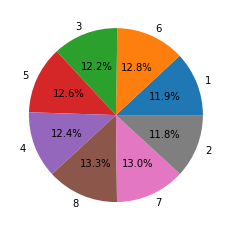

In [18]:
# To create the pie chart of ‘Ranked’
rank_count = combined_df.groupBy("Ranked").count()
rank_count_data = rank_count.collect()
labels = [row['Ranked'] for row in rank_count_data]
sizes = [row['count'] for row in rank_count_data]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

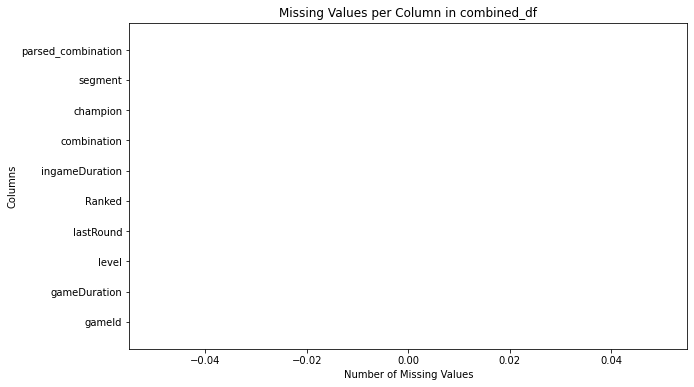

In [19]:
def count_nulls(c):
    return count(when(col(c).isNull(), c)).alias(c)

# Apply to every column
exprs = [count_nulls(c) for c in combined_df.columns]
nulls_df = combined_df.agg(*exprs)

nulls_data = nulls_df.collect()[0].asDict()
columns = list(nulls_data.keys())
values = list(nulls_data.values())

# To create histogram of missing values
plt.figure(figsize=(10, 6))
plt.barh(columns, values, color='skyblue')
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns')
plt.title('Missing Values per Column in combined_df')
plt.show()

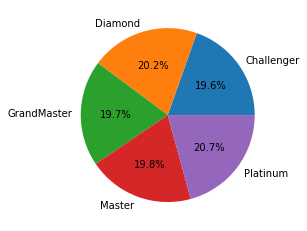

In [20]:
# To create the pie chart of ‘segment’
segment_count = combined_df.groupBy("segment").count()
segment_count_data = segment_count.collect()
labels = [row['segment'] for row in segment_count_data]
sizes = [row['count'] for row in segment_count_data]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

In [10]:
# To create a new attribute 'first_place' to record
combined_df = combined_df.withColumn('first_place', when(col('Ranked') == 1, 1).otherwise(0))
combined_df.select('Ranked', 'first_place').show()

+------+-----------+
|Ranked|first_place|
+------+-----------+
|     2|          0|
|     3|          0|
|     5|          0|
|     6|          0|
|     7|          0|
|     1|          1|
|     3|          0|
|     6|          0|
|     7|          0|
|     8|          0|
|     1|          1|
|     2|          0|
|     3|          0|
|     4|          0|
|     5|          0|
|     6|          0|
|     7|          0|
|     8|          0|
|     1|          1|
|     2|          0|
+------+-----------+
only showing top 20 rows



In [11]:
# To filter the useful attributes
combined_df = combined_df.select("first_place", "combination",  "parsed_combination")
combined_df.show()

+-----------+--------------------+--------------------+
|first_place|         combination|  parsed_combination|
+-----------+--------------------+--------------------+
|          0|{"Blaster":2,"Mer...|{Blaster -> 2, Me...|
|          0|{"Cybernetic":1,"...|{Cybernetic -> 1,...|
|          0|{"Blaster":2,"Dem...|{Blaster -> 2, De...|
|          0|{"Blaster":2,"Dem...|{Blaster -> 2, De...|
|          0|{"Blaster":4,"Chr...|{Blaster -> 4, Ch...|
|          1|{"Blaster":2,"Dem...|{Blaster -> 2, De...|
|          0|{"Chrono":1,"Dark...|{Chrono -> 1, Dar...|
|          0|{"Cybernetic":1,"...|{Cybernetic -> 1,...|
|          0|{"Blaster":4,"Chr...|{Blaster -> 4, Ch...|
|          0|{"DarkStar":1,"Pr...|{DarkStar -> 1, P...|
|          1|{"Blaster":2,"Dem...|{Blaster -> 2, De...|
|          0|{"Blaster":2,"Dem...|{Blaster -> 2, De...|
|          0|{"Demolitionist":...|{Demolitionist ->...|
|          0|{"Blaster":4,"Chr...|{Blaster -> 4, Ch...|
|          0|{"Blaster":2,"Chr...|{Blaster -> 2,

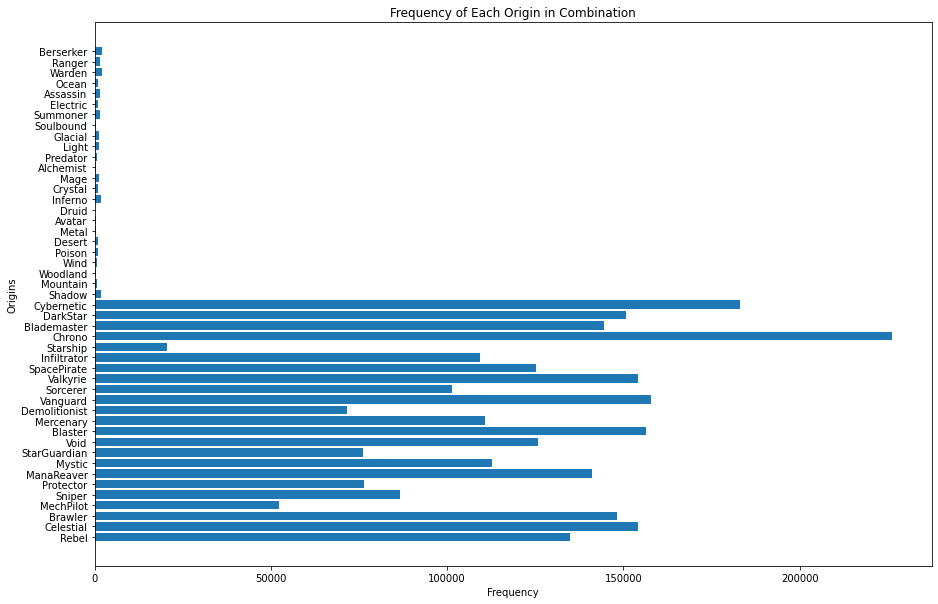

In [23]:
# To create the bar chart of frequency of each origins
key_frequency = combined_df.select(explode(col('parsed_combination')).alias('key', 'value')).groupBy('key').count()
key_freq_data = key_frequency.collect()

keys = [row['key'] for row in key_freq_data]
counts = [row['count'] for row in key_freq_data]

plt.figure(figsize=(15, 10))
plt.barh(keys, counts)
plt.xlabel('Frequency')
plt.ylabel('Origins')
plt.title('Frequency of Each Origin in Combination')
plt.show()

In [12]:
# To filter out origins of S2
excluded_keys = ['Avatar', 'Crystal', 'Inferno', 'Light', 'Mountain', 'Glacial', 
                 'Ranger', 'Shadow', 'Warden', 'Berserker', 'Electric', 'Metal', 
                 'Ocean', 'Poison', 'Predator', 'Desert', 'Summoner', 'Assassin', 
                 'Druid', 'Mage', 'Woodland', 'Wind', 'Alchemist', 'Soulbound']

condition = ' or '.join([f"array_contains(map_keys(parsed_combination), '{k}')" for k in excluded_keys])

combined_df = combined_df.filter(~expr(condition))

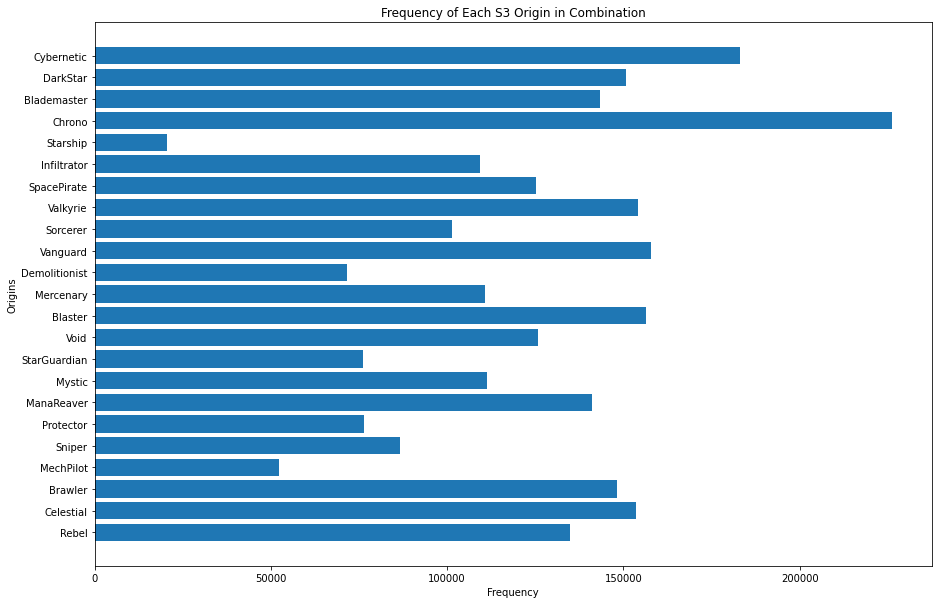

In [25]:
# To create the bar chart of frequency of each origins after filtering
key_frequency = combined_df.select(explode(col('parsed_combination')).alias('key', 'value')).groupBy('key').count()
key_freq_data = key_frequency.collect()

keys = [row['key'] for row in key_freq_data]
counts = [row['count'] for row in key_freq_data]

plt.figure(figsize=(15, 10))
plt.barh(keys, counts)
plt.xlabel('Frequency')
plt.ylabel('Origins')
plt.title('Frequency of Each S3 Origin in Combination')
plt.show()

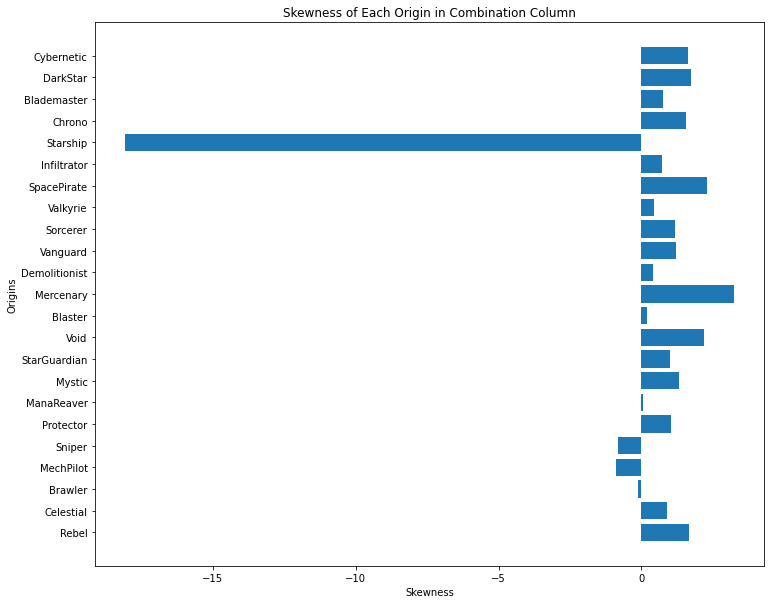

In [26]:
# To calculate skewness of each origin
key_skewness = combined_df.select(explode(col("parsed_combination")).alias("key", "value")) \
                          .groupBy("key") \
                          .agg(skewness(col("value")).alias("skewness"))
skewness_data = key_skewness.collect()
keys = [row['key'] for row in skewness_data]
skewness_values = [row['skewness'] for row in skewness_data]

plt.figure(figsize=(12, 10))
plt.barh(keys, skewness_values)
plt.xlabel('Skewness')
plt.ylabel('Origins')
plt.title('Skewness of Each Origin in Combination Column')
plt.show()

In [27]:
# Cube root transformation
transformed_df = combined_df.withColumn('starship_cbrt', pow(col("parsed_combination").getItem("Starship"), 1/3))
starship_skewness = transformed_df.select(skewness(col("starship_cbrt")).alias("skewness_starship_cbrt"))
starship_skewness.show()

+----------------------+
|skewness_starship_cbrt|
+----------------------+
|   -18.064038793901094|
+----------------------+



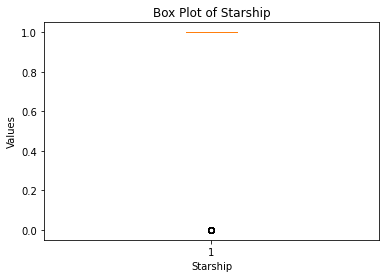

In [28]:
# To create the box plot of 'Starship'
starship_df = combined_df.withColumn('Starship', col('parsed_combination').getItem('Starship'))
pandas_starship_df = starship_df.toPandas()
plt.boxplot(pandas_starship_df['Starship'].dropna())
plt.title('Box Plot of Starship')
plt.xlabel('Starship')
plt.ylabel('Values')
plt.show()

In [13]:
# Split JSON into independent columns
keys_df = combined_df.select(explode(map_keys(col("parsed_combination"))).alias("key")).distinct()
keys = [row['key'] for row in keys_df.collect()]

# Expand JSON into multiple columns
for key in keys:
    combined_df = combined_df.withColumn(key, col("parsed_combination").getItem(key))

#  Fill in missing values if any
combined_df = combined_df.fillna(0)

In [14]:
# Create vector assembler
feature_columns = keys
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

combined_df = assembler.transform(combined_df)

In [15]:
# 70% train，30% test
train_df, test_df = combined_df.randomSplit([0.7, 0.3])

# Outcomes
print(f"Training Dataset Count: {train_df.count()}")
print(f"Test Dataset Count: {test_df.count()}")

24/05/20 04:39:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Training Dataset Count: 231343


Test Dataset Count: 98749


In [16]:
# Dataset repartition
train_df = train_df.repartition(200)
test_df = test_df.repartition(200)
# Change the 'first_place' into Double type
train_df = train_df.withColumn("first_place", col("first_place").cast("double"))
test_df = test_df.withColumn("first_place", col("first_place").cast("double"))

In [17]:
#Create Random Forest model
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='first_place',
    numTrees=200,
    maxDepth=5
)

model = rf.fit(train_df)

24/05/20 04:29:12 WARN DAGScheduler: Broadcasting large task binary with size 1037.5 KiB


In [18]:
# Use the model to predict
prediction_rf = model.transform(test_df)
prediction_rf.select("prediction", "first_place", "features").show(5)

+----------+-----------+--------------------+
|prediction|first_place|            features|
+----------+-----------+--------------------+
|       0.0|        1.0|(23,[1,4,5,6,13,1...|
|       0.0|        0.0|(23,[0,2,9,10,11,...|
|       0.0|        0.0|(23,[0,2,8,9,10,1...|
|       0.0|        0.0|(23,[0,2,7,10,11,...|
|       0.0|        0.0|(23,[0,1,2,7,9,10...|
+----------+-----------+--------------------+
only showing top 5 rows



In [19]:
# Select (prediction, true label) and compute test error.
evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="accuracy")

In [20]:
# Calculate test error
accuracy = evaluator.evaluate(prediction_rf)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.118814


In [21]:
# Create confusion martix
predictionAndLabels = prediction_rf.select("prediction", "first_place")

predictionAndLabels_rdd = predictionAndLabels.rdd.map(lambda row: (row[0], row[1]))

metrics = MulticlassMetrics(predictionAndLabels_rdd)
confusion_matrix = metrics.confusionMatrix().toArray()

# Outcome
print("Confusion Matrix:")
print(confusion_matrix)

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[87493.     0.]
 [11797.     0.]]


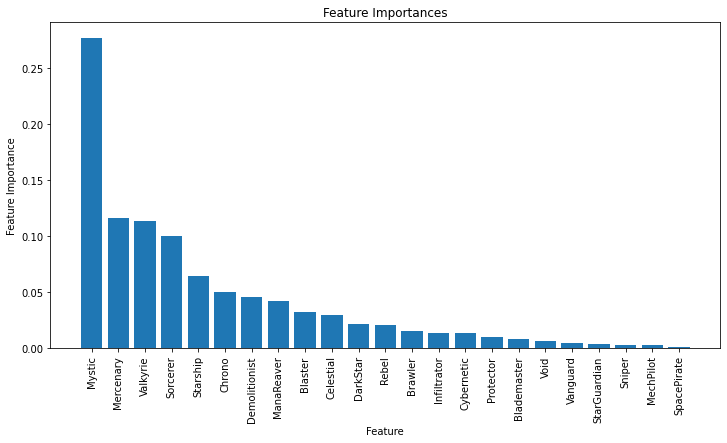

In [22]:
# Create feature importance
importances = model.featureImportances

feature_names = [attr["name"] for attr in train_df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]]

feature_importance_list = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

features, importances = zip(*feature_importance_list)

plt.figure(figsize=(12, 6))
plt.bar(features, importances, align='center')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

In [23]:
# Performance metrics
precision_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(prediction_rf)
recall = recall_evaluator.evaluate(prediction_rf)
f1 = f1_evaluator.evaluate(prediction_rf)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.881186423607614
Precision: 0.7764895131503774
Recall: 0.881186423607614
F1 Score: 0.8255317000016167


In [24]:
# Iteration 1 : Change the ratio of train and test

# 80% train，20% test
train_df_I1, test_df_I1 = combined_df.randomSplit([0.8, 0.2])

# Outcomes
print(f"Training Dataset Count: {train_df_I1.count()}")
print(f"Test Dataset Count: {test_df_I1.count()}")

# Dataset repartition
train_df_I1 = train_df_I1.repartition(200)
test_df_I1 = test_df_I1.repartition(200)
# Change the 'first_place' into Double type
train_df_I1 = train_df_I1.withColumn("first_place", col("first_place").cast("double"))
test_df_I1 = test_df_I1.withColumn("first_place", col("first_place").cast("double"))

Training Dataset Count: 263867


Test Dataset Count: 66225


In [25]:
# Create Random Forest model
rf_I1 = RandomForestClassifier(
    featuresCol='features',
    labelCol='first_place',
    numTrees=200,
    maxDepth=5
)
# Train model
model_I1 = rf_I1.fit(train_df_I1)

24/05/20 04:34:23 WARN DAGScheduler: Broadcasting large task binary with size 1038.9 KiB


In [26]:
# Use the model to predict
prediction_rf_I1 = model.transform(test_df_I1)

# Performance metrics of I1
evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="f1")

accuracy_I1 = evaluator.evaluate(prediction_rf_I1)
precision_I1 = precision_evaluator.evaluate(prediction_rf_I1)
recall_I1 = recall_evaluator.evaluate(prediction_rf_I1)
f1_I1 = f1_evaluator.evaluate(prediction_rf_I1)

print(f"Accuracy_I1: {accuracy_I1}")
print(f"Precision_I1: {precision_I1}")
print(f"Recall_I1: {recall_I1}")
print(f"F1 Score_I1: {f1_I1}")

Accuracy_I1: 0.8798640996602491
Precision_I1: 0.7741608338709408
Recall_I1: 0.8798640996602491
F1 Score_I1: 0.8236348936190188


In [17]:
# Iteration 2 : Change the parameters

# Create Random Forest model with different parameters
rf_I2 = RandomForestClassifier(
    featuresCol='features',
    labelCol='first_place',
    numTrees=400,
    maxDepth=5
)
# Train model
model_I2 = rf_I2.fit(train_df)

24/05/20 04:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1009.3 KiB
24/05/20 04:42:37 WARN DAGScheduler: Broadcasting large task binary with size 1927.2 KiB


In [18]:
# Use the model to predict
prediction_rf_I2 = model_I2.transform(test_df)

#Performance metrics of I2
evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="f1")

accuracy_I2 = evaluator.evaluate(prediction_rf_I2)
precision_I2 = precision_evaluator.evaluate(prediction_rf_I2)
recall_I2 = recall_evaluator.evaluate(prediction_rf_I2)
f1_I2 = f1_evaluator.evaluate(prediction_rf_I2)

print(f"Accuracy_I2: {accuracy_I2}")
print(f"Precision_I2: {precision_I2}")
print(f"Recall_I2: {recall_I2}")
print(f"F1 Score_I2: {f1_I2}")

24/05/20 04:43:56 WARN DAGScheduler: Broadcasting large task binary with size 1378.8 KiB
24/05/20 04:44:16 WARN DAGScheduler: Broadcasting large task binary with size 1378.8 KiB
24/05/20 04:44:33 WARN DAGScheduler: Broadcasting large task binary with size 1378.8 KiB
24/05/20 04:44:51 WARN DAGScheduler: Broadcasting large task binary with size 1378.8 KiB


Accuracy_I2: 0.8809911999108851
Precision_I2: 0.7761454943204212
Recall_I2: 0.8809911999108851
F1 Score_I2: 0.8252515953899119


In [19]:
# Iteration 3: Feature transformation

# Normalization
scaler_I3 = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

#Create Random Forest model
rf_I3 = RandomForestClassifier(
    featuresCol='scaledFeatures',
    labelCol='first_place',
    numTrees=200,
    maxDepth=5
)

# Define pipeline
pipeline_I3 = Pipeline(stages=[scaler_I3, rf_I3])

In [20]:
# Train model
model_I3 = pipeline_I3.fit(train_df)

24/05/20 04:47:21 WARN DAGScheduler: Broadcasting large task binary with size 1044.8 KiB


In [21]:
# Use the model to predict
prediction_rf_I3 = model_I3.transform(test_df)

#Performance metrics of I3
evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="f1")

accuracy_I3 = evaluator.evaluate(prediction_rf_I3)
precision_I3 = precision_evaluator.evaluate(prediction_rf_I3)
recall_I3 = recall_evaluator.evaluate(prediction_rf_I3)
f1_I3 = f1_evaluator.evaluate(prediction_rf_I3)

print(f"Accuracy_I3: {accuracy_I3}")
print(f"Precision_I3: {precision_I3}")
print(f"Recall_I3: {recall_I3}")
print(f"F1 Score_I3: {f1_I3}")

Accuracy_I3: 0.8809911999108851
Precision_I3: 0.7761454943204212
Recall_I3: 0.8809911999108851
F1 Score_I3: 0.8252515953899119


In [22]:
# Iteration 4: Change the model

# standardization
scaler_I4 = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# Create LSVC model
lsvc_I4 = LinearSVC(featuresCol="scaledFeatures", labelCol="first_place", maxIter=10, regParam=0.1)

# Define pipeline
pipeline_I4 = Pipeline(stages=[scaler_I4, lsvc_I4])


In [23]:
# Train model
model_I4 = pipeline_I4.fit(train_df)

24/05/20 04:50:45 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/20 04:50:45 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [24]:
# Use the model to predict
prediction_rf_I4 = model_I4.transform(test_df)

#Performance metrics of I4
evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="first_place", predictionCol="prediction", metricName="f1")

accuracy_I4 = evaluator.evaluate(prediction_rf_I4)
precision_I4 = precision_evaluator.evaluate(prediction_rf_I4)
recall_I4 = recall_evaluator.evaluate(prediction_rf_I4)
f1_I4 = f1_evaluator.evaluate(prediction_rf_I4)

print(f"Accuracy_I4: {accuracy_I4}")
print(f"Precision_I4: {precision_I4}")
print(f"Recall_I4: {recall_I4}")
print(f"F1 Score_I4: {f1_I4}")

Accuracy_I4: 0.8809911999108851
Precision_I4: 0.7761454943204212
Recall_I4: 0.8809911999108851
F1 Score_I4: 0.8252515953899119
